# 参考サイト  
[コンペサイト アップル 引越し需要予測](https://signate.jp/competitions/269/data)  
[SIGNATE SOTA アップル 引越し需要予測 備忘録](https://zenn.dev/tremendous1192/articles/ea6e73359ee764)  


# 概要

ここでやっていること
- clientフラグについて
- 料金区分について
    - 午前料金
    - 午後料金
    - 欠損している期間がある？

# ライブラリのインポート

In [17]:
import polars as pl
import polars.selectors as cs
pl.Config.set_fmt_str_lengths(100)
pl.Config.set_tbl_cols(100)
import numpy as np

import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
%matplotlib inline

import plotly.express as px
import plotly.graph_objects as go

from datetime import date
import matplotlib.dates as mdates

import jpholiday

from prophet import Prophet

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

# EDA1までの処理をまとめたもの

In [ ]:
# データを読み込む
train = pl.read_csv("../data/input/train.csv")
test = pl.read_csv("../data/input/test.csv")
sample_submit = pl.read_csv("../data/input/sample_submit.csv", has_header = False)

# IDと日時を分散する
train = train.insert_column(0, train["datetime"].alias("id")).with_columns(pl.col("datetime").str.strptime(dtype = pl.Date))
test = test.insert_column(0, test["datetime"].alias("id")).with_columns(pl.col("datetime").str.strptime(dtype = pl.Date))

# 休業日(close==1)(と、お盆だけど休業していなくて結局引っ越し数0だった日)を分離する
train = train.filter(
    (pl.col("close") != 1)
    & (pl.col("id") != "2010-08-18")
    & (pl.col("id") != "2011-08-14")
)
test_close = test.filter(pl.col("close") == 1)[["id"]]
test_close = test_close.with_columns(pl.Series("y", [0.0] * len(test_close)))
test = test.filter(pl.col("close") != 1)

# 目的変数を対数変換する
train = train.insert_column(3, train["y"].log().alias("y_ln"))

train = train.drop("close")
test = test.drop("close")

# clientフラグについて

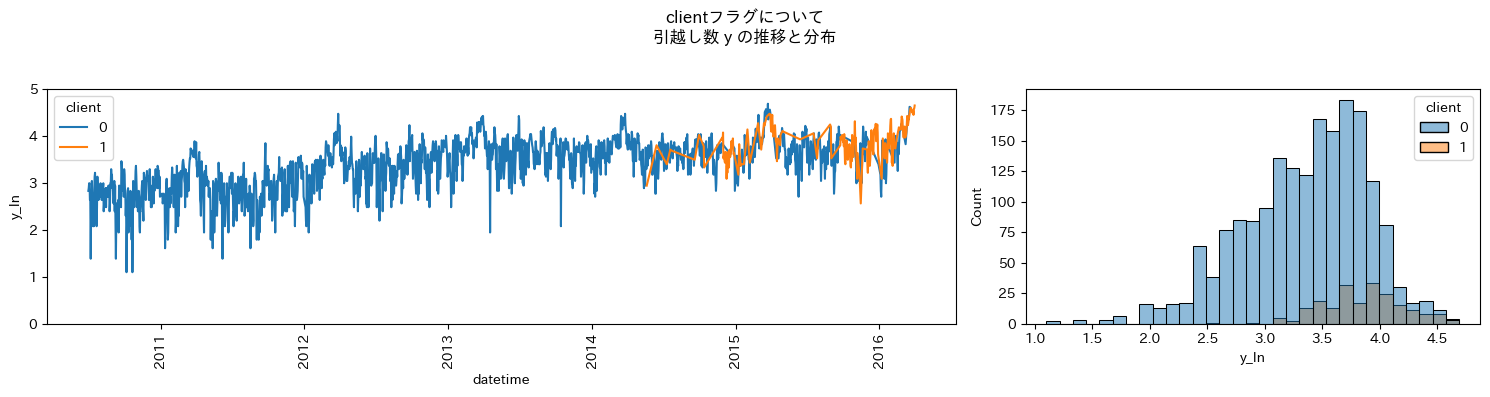

shape: (206, 7)
┌────────────┬────────────┬─────┬──────────┬────────┬──────────┬──────────┐
│ id         ┆ datetime   ┆ y   ┆ y_ln     ┆ client ┆ price_am ┆ price_pm │
│ ---        ┆ ---        ┆ --- ┆ ---      ┆ ---    ┆ ---      ┆ ---      │
│ str        ┆ date       ┆ i64 ┆ f64      ┆ i64    ┆ i64      ┆ i64      │
╞════════════╪════════════╪═════╪══════════╪════════╪══════════╪══════════╡
│ 2014-05-20 ┆ 2014-05-20 ┆ 19  ┆ 2.944439 ┆ 1      ┆ 0        ┆ 0        │
│ 2014-06-14 ┆ 2014-06-14 ┆ 45  ┆ 3.806662 ┆ 1      ┆ 1        ┆ 1        │
│ 2014-07-10 ┆ 2014-07-10 ┆ 30  ┆ 3.401197 ┆ 1      ┆ 0        ┆ 0        │
│ 2014-07-19 ┆ 2014-07-19 ┆ 41  ┆ 3.713572 ┆ 1      ┆ 2        ┆ 1        │
│ 2014-07-23 ┆ 2014-07-23 ┆ 40  ┆ 3.688879 ┆ 1      ┆ 0        ┆ 0        │
│ …          ┆ …          ┆ …   ┆ …        ┆ …      ┆ …        ┆ …        │
│ 2016-03-27 ┆ 2016-03-27 ┆ 94  ┆ 4.543295 ┆ 1      ┆ 5        ┆ 4        │
│ 2016-03-28 ┆ 2016-03-28 ┆ 86  ┆ 4.454347 ┆ 1      ┆ 4        ┆ 4      

In [19]:
fig, axes = plt.subplots(
    nrows=1, ncols=2,
    height_ratios=[1], width_ratios=[2, 1],
    figsize=(15, 4)
)

g_time = sns.lineplot(data=train, x="datetime", y="y_ln", hue="client", ax=axes[0])
g_hist = sns.histplot(data=train, x="y_ln", hue="client", ax=axes[1])

plt.setp(g_time.get_xticklabels(), rotation = 90)
plt.setp(g_time, ylim = (0, 5))

plt.suptitle("clientフラグについて\n引越し数 y の推移と分布")
plt.tight_layout(rect = [0, 0, 1, 0.96])# 余白の調整  
plt.show()
print(train.filter(pl.col("client") == 1))

2014年5月からclient(法人が絡む特殊な引越し日フラグ)に関する何かが始まっているみたい  
それが何のことなのかは良くわからんけど…日にちに対してフラグが立っている  
→多分、「この日は法人からの依頼があった」ということ？yの内何件がそれだったのかはわからんけど⋯

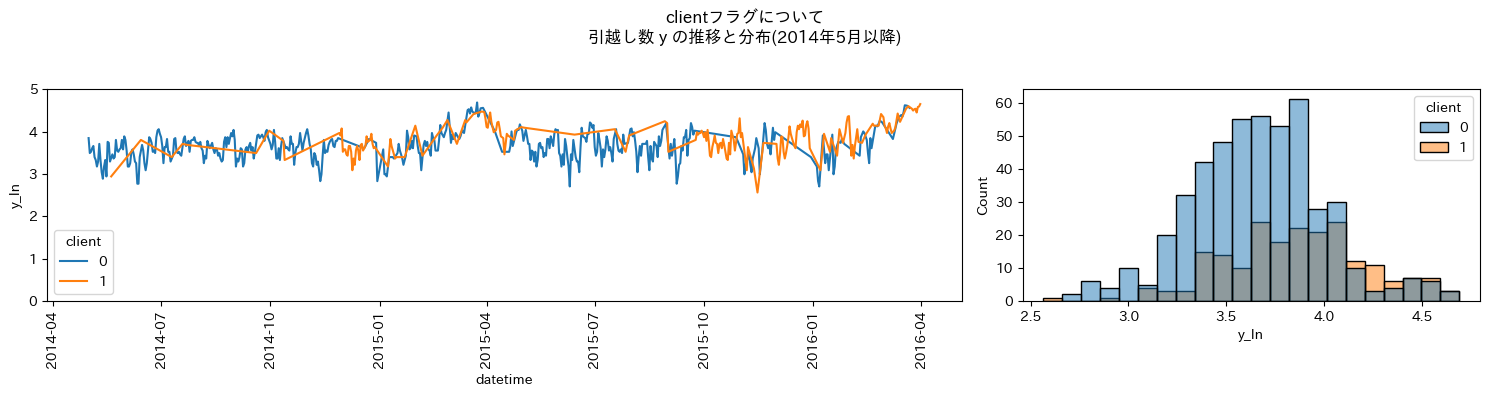

In [20]:
# 期間を絞り込んで表示。
fig, axes = plt.subplots(
    nrows=1, ncols=2,
    height_ratios=[1], width_ratios=[2, 1],
    figsize=(15, 4)
)

g_time = sns.lineplot(data=train.filter(pl.col("datetime") >= date(2014, 5, 1)), x="datetime", y="y_ln", hue="client", ax=axes[0])
g_hist = sns.histplot(data=train.filter(pl.col("datetime") >= date(2014, 5, 1)), x="y_ln", hue="client", ax=axes[1])

plt.setp(g_time.get_xticklabels(), rotation = 90)
plt.setp(g_time, ylim = (0, 5))

plt.suptitle("clientフラグについて\n引越し数 y の推移と分布(2014年5月以降)")
plt.tight_layout(rect = [0, 0, 1, 0.96])# 余白の調整  
plt.show()

client=1のときは、そうでないときと比べてy_lnの分布が右にシフトする。つまり引っ越し数が通常より多めの傾向になる模様  
(たぶん。そこまで顕著ではないけど。恐らくclient=1による影響だと思うけど…)

In [21]:
print("client=1(法人あり)のときの引っ越し数yの平均",
      np.round(train.filter(pl.col("datetime") >= date(2014, 5, 1))
               .filter(pl.col("client") == 1)["y"].mean(), decimals=2)
      )
print("client=0(通常時)のときの引っ越し数yの平均",
      np.round(train.filter(pl.col("datetime") >= date(2014, 5, 1))
               .filter(pl.col("client") == 0)["y"].mean(), decimals=2)
      )

client=1(法人あり)のときの引っ越し数yの平均 50.58
client=0(通常時)のときの引っ越し数yの平均 41.26


-1は欠損。0~5で数値が高いほど料金が高い  
グラフより、y_lnが小さいところは料金を低くしており、y_lnが高いところは料金が高くなっていることが分かる  
説明通り、繁忙期は料金を高くして調整しようとしていることが見て取れる  
所々、料金設定ミスっているところもある？(料金設定高めなのにy_ln低め)  
あと、2010年の料金区分のデータが欠損している？

# 料金区分を見てみる(午前、午後)

## 午前

In [22]:
graph_color = px.colors.sequential.Magma_r
# https://oeconomicus.jp/2021/07/plotly-color-scale/

# pandas にしてカテゴリ順を明示（数値をソート）
df = train.to_pandas()
cats = sorted(df["price_am"].unique().tolist())

# カラー列もカテゴリ数に合わせる
colors = graph_color[:len(cats)]

fig_time = px.line(
    df,
    x="datetime",
    y="y_ln",
    color="price_am",
    category_orders={"price_am": cats},
    color_discrete_sequence=colors,
)

fig_hist = px.histogram(
    df,
    x="y_ln",
    color="price_am",
    category_orders={"price_am": cats},
    color_discrete_sequence=colors,
)

from plotly.subplots import make_subplots

fig = make_subplots(
    rows=1, cols=2,
    horizontal_spacing=0.05,
    subplot_titles=("推移", "分布"),
    column_widths=[0.7, 0.3]
)

# 時系列のトレースを追加
for trace in fig_time.data:
    fig.add_trace(trace, row=1, col=1)

# ヒストグラムのトレースを追加
for trace in fig_hist.data:
    # trace.update(showlegend=False)
    fig.add_trace(trace, row=1, col=2)

fig.update_xaxes(title_text="datetime", row=1, col=1)
fig.update_yaxes(title_text="y_ln", row=1, col=1)
fig.update_xaxes(title_text="y_ln", row=1, col=2)
fig.update_yaxes(title_text="count", row=1, col=2)

fig.update_layout(
    width=1500,
    title_text="午前料金区分別<br>引越し数 y の推移と分布",
    showlegend=True
)

del df

fig.show()

## 午後

In [23]:
graph_color = px.colors.sequential.Magma_r
# https://oeconomicus.jp/2021/07/plotly-color-scale/

# pandas にしてカテゴリ順を明示（数値をソート）
df = train.to_pandas()
cats = sorted(df["price_pm"].unique().tolist())

# カラー列もカテゴリ数に合わせる
colors = graph_color[:len(cats)]

fig_time = px.line(
    df,
    x="datetime",
    y="y_ln",
    color="price_pm",
    category_orders={"price_pm": cats},
    color_discrete_sequence=colors,
)

fig_hist = px.histogram(
    df,
    x="y_ln",
    color="price_pm",
    category_orders={"price_pm": cats},
    color_discrete_sequence=colors,
)

from plotly.subplots import make_subplots

fig = make_subplots(
    rows=1, cols=2,
    horizontal_spacing=0.05,
    subplot_titles=("推移", "分布"),
    column_widths=[0.7, 0.3]
)

# 時系列のトレースを追加
for trace in fig_time.data:
    fig.add_trace(trace, row=1, col=1)

# ヒストグラムのトレースを追加
for trace in fig_hist.data:
    # trace.update(showlegend=False)
    fig.add_trace(trace, row=1, col=2)

fig.update_xaxes(title_text="datetime", row=1, col=1)
fig.update_yaxes(title_text="y_ln", row=1, col=1)
fig.update_xaxes(title_text="y_ln", row=1, col=2)
fig.update_yaxes(title_text="count", row=1, col=2)

fig.update_layout(
    width=1500,
    title_text="午後料金区分別<br>引越し数 y の推移と分布",
    showlegend=True
)

del df

fig.show()

午後についても、午前と概ね同じ傾向  
やっぱり2010年については欠損しているみたい

## 料金区分price_am, price_pmが3以上のものを詳しく見てみる

In [24]:
# 料金区分price_am, price_pmが3以上のものを詳しく見てみる
with pl.Config(tbl_rows=-1):
    print(
        train.filter(
            (pl.col("price_am") >= 3) | (pl.col("price_pm") >= 3)
        )
    )

shape: (114, 7)
┌────────────┬────────────┬─────┬──────────┬────────┬──────────┬──────────┐
│ id         ┆ datetime   ┆ y   ┆ y_ln     ┆ client ┆ price_am ┆ price_pm │
│ ---        ┆ ---        ┆ --- ┆ ---      ┆ ---    ┆ ---      ┆ ---      │
│ str        ┆ date       ┆ i64 ┆ f64      ┆ i64    ┆ i64      ┆ i64      │
╞════════════╪════════════╪═════╪══════════╪════════╪══════════╪══════════╡
│ 2011-02-26 ┆ 2011-02-26 ┆ 32  ┆ 3.465736 ┆ 0      ┆ 3        ┆ 2        │
│ 2011-03-19 ┆ 2011-03-19 ┆ 40  ┆ 3.688879 ┆ 0      ┆ 3        ┆ 3        │
│ 2011-03-20 ┆ 2011-03-20 ┆ 41  ┆ 3.713572 ┆ 0      ┆ 5        ┆ 3        │
│ 2011-03-21 ┆ 2011-03-21 ┆ 39  ┆ 3.663562 ┆ 0      ┆ 3        ┆ 2        │
│ 2011-03-22 ┆ 2011-03-22 ┆ 39  ┆ 3.663562 ┆ 0      ┆ 3        ┆ 3        │
│ 2011-03-23 ┆ 2011-03-23 ┆ 37  ┆ 3.610918 ┆ 0      ┆ 5        ┆ 4        │
│ 2011-03-24 ┆ 2011-03-24 ┆ 36  ┆ 3.583519 ┆ 0      ┆ 5        ┆ 3        │
│ 2011-03-25 ┆ 2011-03-25 ┆ 35  ┆ 3.555348 ┆ 0      ┆ 4        ┆ 5      

3月、4月に高めの料金設定をしていることが見て取れる  
│ id         ┆ datetime   ┆ y   ┆ y_ln     ┆ client ┆ price_am ┆ price_pm │  
│ 2011-12-30 ┆ 2011-12-30 ┆ 15  ┆ 2.70805  ┆ 0      ┆ 1        ┆ 3        │  
ってなってるけど、これは年末に一応営業したけど午後はスタッフ全然居ないから値付けを高くして調整しようとしたのか？

In [25]:
print("2010年のデータ数",
      len(train.filter(pl.col("datetime") <= date(2010, 12, 31)))
      )
print("2010年でprice_am=-1(欠損)となっているデータ数",
      len((train.filter(pl.col("datetime") <= date(2010, 12, 31))).filter(pl.col("price_am") == -1))
      )
print("2010年でprice_pm=-1(欠損)となっているデータ数",
      len((train.filter(pl.col("datetime") <= date(2010, 12, 31))).filter(pl.col("price_pm") == -1))
      )

2010年のデータ数 182
2010年でprice_am=-1(欠損)となっているデータ数 182
2010年でprice_pm=-1(欠損)となっているデータ数 182


2010年のデータは料金設定という大事なデータが欠損しているため、学習からは外すべし

In [26]:
# train = train.filter(pl.col("datetime") >= date(2011, 1, 1))

# EDAのまとめ
1. 目的変数yが増加傾向のため、年毎の分布が右にシフトしている。
    - to do: 年毎の目的変数yの分布を揃える必要がある。  
2. 目的変数yは繁忙期(3月、4月)とそれ以外の時期で分布が異なる
3. 休業日close = 1は目的変数y = 0のため、休業日を分離した。
4. 目的変数y = 0の分布の右側の裾野が広いので対数変換で裾野を狭めた。
5. 法人対応clientを2014年度から始めた
6. 法人が絡む特殊な引越しを行う場合(close = 1)、目的変数の平均値が約9増える
7. 料金区分(price_amとprice_pm)は、繁忙期に高い価格を設定している
8. 2010年の料金区分が全て欠測値のため削除した
9. 午後の料金区分は午前よりも安い傾向にある。